In [68]:
import re, string,os
from glob import glob as gb
import pandas as pd
from tqdm import tqdm
from collections import Counter
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from functions import *
from datetime import datetime
import matplotlib as mpl
from matplotlib.colors import Normalize
from matplotlib import cm
import spacy 

nlp = spacy.load('en_core_web_sm')
plotting.style_()

from nltk.corpus import stopwords

base_path = "/home/ruben/Documents/GitHub/ParlaMintCase"

In [62]:
df = data_loader.period(language="gb",data_version="lemmatized",start_date="2020-02",end_date="2020-04")
df = df[df['id'].astype(str).str.len() > 2].dropna().reset_index(drop=True)
df['date'] = [utils.find_date(x)[:10] for x in df['id']]
df = df[df.id.astype(str).str.contains('-commons')]
df = utils.add_metadata(df,'gb')
df['text'] = utils.preprocess_(df['text'],stopwords=set(stopwords.words('english')) | set("hon. friend right gentleman people government hon member".split(' ')))
df['text'] = [re.sub(r'[^A-Za-z0-9 ]+', '', str(s)) for s in df['text']]
df = df.reset_index(drop=True)

found 57 files


In [49]:
avgs = {}

for date_ in sorted(list(set(df['date']))):
    t = df[(df.date == date_) & (df.speaker_party != '-')].reset_index(drop=True)
    t['p'] = [polyglot_classifier(x) for x in t['text']]
    avgs.update({date_:t['p'].mean()})

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

In [52]:
avgs

{'2020-02-03': 0.045706686426655735,
 '2020-02-04': 0.03468106558097858,
 '2020-02-05': 0.028321347706067358,
 '2020-02-06': 0.03221973966486501,
 '2020-02-10': -0.009690510781198666,
 '2020-02-11': 0.04459254392504656,
 '2020-02-12': 0.008051154459026514,
 '2020-02-13': 0.03461244197160934,
 '2020-02-24': 0.02700342657660383,
 '2020-02-25': 0.0006646056612633609,
 '2020-02-26': 0.03541981365977881,
 '2020-02-27': 0.03367847193687953,
 '2020-03-02': 0.04149211945583778,
 '2020-03-03': 0.028317376944320898,
 '2020-03-04': 0.024584314721033673,
 '2020-03-05': 0.04949279921941483,
 '2020-03-09': 0.054503351872587945,
 '2020-03-10': 0.02716784316400722,
 '2020-03-11': 0.02877140073467223,
 '2020-03-12': 0.034836104615621366,
 '2020-03-13': 0.04692565484955212,
 '2020-03-16': 0.0371133613368251,
 '2020-03-17': 0.052110420062124345,
 '2020-03-18': 0.04351130460595563,
 '2020-03-19': 0.02755951607818537,
 '2020-03-23': 0.01348625636222099,
 '2020-03-24': 0.04265252476828612,
 '2020-03-25': 0.

In [83]:
tfidf_obj,docterms = tfidf.get_docterms(df,'text')

def polyglot_classifier(text):
    try:
        text = Text(text)
        r = sum([w.polarity for w in text.words]) / len(text.words)
        return r
    except Exception as e:
        return float("nan")

def plot_(date_,format_='party'):
    colors_ = {'-':'grey','A':'teal','CON':'tab:blue', 'CON;I':'gold', 'DUP':'tab:purple', 'GP':'tab:green', 'I':'gold', 'LAB':'tab:red', 'LAB;S':'tab:brown', 'LD':'tab:cyan', 'PC':'tab:gray', 'SNP':'tab:orange'}
    party_names = {k:v.replace(';',' - ') for k,v in dict(zip(df['speaker_party'],df['speaker_party_name'])).items()}

    t = df[(df.date == date_) & (df.speaker_party != '-')].reset_index(drop=True)
    t['x'] = [int(c) for c,i in enumerate(t['speaker_type'])]
    # t['y'] = [positions[x] for x in t['speaker_party']]
    t['size'] = [math.log(len(x)) for x in t['text']]
    t['p'] = [polyglot_classifier(x) for x in t['text']]
    fig,ax = plt.subplots(figsize=(20,3))
    bars = plt.bar(x=t['x'],height=t['size'],width=1)

    mn = Normalize(vmin=-0.4,vmax=0.4)
    mcm = cm.get_cmap('coolwarm')
    mcm = mcm(mn(t['p']))

    dfn = pd.DataFrame()
    dfn = dfn.append(df[df['date'] != date_].sample(1500))
    dfn = dfn.append(df[df['date'] == date_]).reset_index(drop=True)

    df['dl'] = ["day" if dat == date_ else "other" for dat in df['date']]
    tftw = tfidf.get_topterms(tfidf_obj,docterms,df,'dl')
    typical_words = tftw['day'][:100]
    typical_words = [w.lemma_ for w in nlp(" ".join(typical_words)) if w.pos_ in ["NOUN"]][:5]

    if format_ == 'party':
        for c,i in enumerate(bars):
            i.set_color(colors_[t['speaker_party'][c]])
        
        labels = [n for n in list(colors_.keys()) if n in set(t['speaker_party'])]
        handles = [plt.Rectangle((0,0),1,1, color=colors_[label]) for label in labels]
        plt.legend(handles, [party_names[x] for x in labels],loc='upper left',bbox_to_anchor=(1,1.05))
        plt.axis('off')
        plt.title('PARTY | '+date_.upper() + ' ' + " | TF-IDF top terms:"+ ' ' + ", ".join(typical_words))
        plt.show()
    if format_ == 'polarity':
        for c,i in enumerate(bars):
            i.set_color(mcm[c])
        plt.axis('off')
        plt.title('POLARITY | '+date_.upper() + ' ' + " | TF-IDF top terms:"+ ' ' + ", ".join(typical_words))
        plt.show()    

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


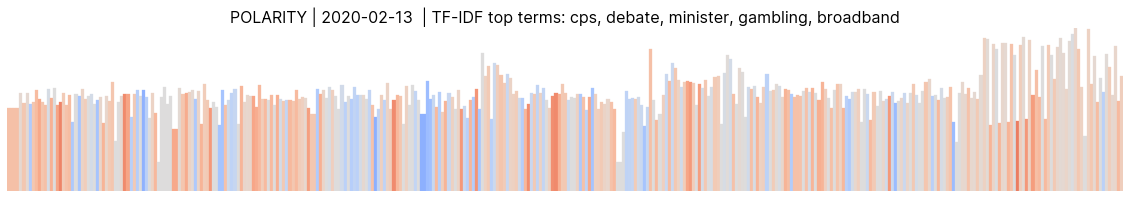

In [84]:
plot_('2020-02-13',format_='polarity')

In [88]:
plot_('2020-02-23',format_='party')

KeyError: 'day'